## Global Navigation

The goal of this part is to create a trajectory that will allow the Thymio to pass through several interest point and come back to his initial position.

The trajectory has to ensure that the Thymio avoid the global obstacles detected by the camera.

### Pass planning : Process flow

The creation of our trajectory is composed of the following steps :

- Dilatation of the obstacles to avoid collisions.

- Visibility graph computation by using the previously dilated obstacles.

- Pass planning computation by using the visibility graph and the interest point positions.

#### Obstacle dilatation

To perform the obstacle dilatation, we have implemented two different algorithms in parallel with the aim of taking the one that will provide the best results.

The first algorithm that we used is based on the dilatation function provided in the OpenCV library :

- Find the contours of the global obstacles.

- Create a grayscale image with the global obstacles in white and the rest in black.

- Dilate the global obstacles in this image.

- Find the new dilated contours.

For more details on the OpenCV dilatation function, see [Morphological transformations in OpenCV](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html).

In [23]:
import cv2
import sys
import numpy as np

sys.path.append("../vision")

from vision import *

In [36]:
#RED_LOW  = [150, 100, 100]
#RED_HIGH = [179, 255, 255]

#DIL_COEFF_K = 15


def detect_obstacles(frame, scale=1):
    
    # Find the contours of the global obstacles
    frame = frame.copy()
    red_low = np.array(RED_LOW, np.uint8)
    red_high = np.array(RED_HIGH, np.uint8)
    
    clean_contours = find_color(frame, red_low, red_high)
    
    
    # Some operations used for plotting purposes and scalling of the image in real dimmensions
    cv2.drawContours(frame, clean_contours, -1, (0,255,0), 3)
            
    original_contours = []
    for cnt in clean_contours:
        ocnt = []
        for pt in cnt:
            ocnt.append(pt[0])
        original_contours.append(np.multiply(ocnt, scale).astype(int))
        
        
    # Create a grayscale image with the global obstacles in white and the rest in black
    black = np.zeros(frame.shape[:2], dtype=np.uint8)
    
    for i in range(len(clean_contours)):
        cv2.drawContours(black, clean_contours, i, (255), -1)

    plt.figure()
    plt.imshow(black)
    
    
    # Dilate the global obstacles in this image
    kernel = np.ones((DIL_COEFF_K,DIL_COEFF_K),np.uint8)
    black = cv2.dilate(black, kernel, iterations = 15)

    plt.figure()
    plt.imshow(black)
    
    
    # Find the new dilated contours
    contours, hierarchy = cv2.findContours(black, cv2.RETR_EXTERNAL  , cv2.CHAIN_APPROX_SIMPLE)
    
    clean_dil_contours = cleanup_contours(contours, 1)

    
    # Some operations used for plotting purposes and scalling of the image in real dimmensions
    scaled_contours = []
    for cnt in clean_dil_contours:
        ncnt = []
        for pt in cnt:
            frame = cv2.circle(frame, (pt[0][0], pt[0][1]), radius=5, color=(0, 0, 255), thickness=-1)
            ncnt.append(pt[0])

        scaled_contours.append(np.multiply(ncnt, scale).astype(int))
    
    
    return scaled_contours, original_contours, frame

To see the result of our algorithm, we will use the following function (note that this function will be also used to plot other results computed in the global Navigation part) :

In [37]:
import matplotlib.pyplot as plt

In [38]:
X = 0
Y = 1

def printGlobalNavigation(contours, contoursMapped, possibleDisplacement = {}, interestPoints = [], trajectory = []):
    """Plot the original contours and the dilated contours using matplotlib
       Plot the visibility graph if possibleDisplacement is given 
       Plot the Thymio's point of interest if interestPoints is given
       Plot the Thymio's path if the trajectory is given

    Parameters
    ----------
    contours : list of list of list
        The camera detect several obstacles
        Each obstacle has several extremities
        Each extremity has (x, y) coordinates

    contoursMapped : list of list of list
        Same structure as contours, each extremity's coordinate has been dilated

    possibleDispacement : dictionary
        Each extremity point has several visible points, i.e possible destinations for the Thymio

    interestPoints : list of list
        Each point of interest has (x, y) coordinates, i.e locations where the thymio need to go

    trajectory : list of list
        Each point of the trajectory has (x, y) coordinates

    Returns
    -------

    """

    xOriginal = []
    yOriginal = []
    xDilated = []
    yDilated = []

    for obstacleOriginal in contours:
        for extremityOriginal in obstacleOriginal:
            xOriginal.append(extremityOriginal[X])
            yOriginal.append(extremityOriginal[Y])

        xOriginal.append(obstacleOriginal[0][X])
        yOriginal.append(obstacleOriginal[0][Y])

        plt.plot(xOriginal, yOriginal, 'b')

        xOriginal.clear()
        yOriginal.clear()

    
    for obstacleDilated in contoursMapped:
        for extremityDilated in obstacleDilated:
            xDilated.append(extremityDilated[X])
            yDilated.append(extremityDilated[Y])

        xDilated.append(obstacleDilated[0][X])
        yDilated.append(obstacleDilated[0][Y])

        plt.plot(xDilated, yDilated, 'm')

        xDilated.clear()
        yDilated.clear()


    if possibleDisplacement:
        for extremity in possibleDisplacement:
            for visiblePoint in possibleDisplacement[extremity]:
                plt.plot([extremity[X], visiblePoint[X]], [extremity[Y], visiblePoint[Y]], 'm')

    
    if interestPoints:
        for point in interestPoints:
            plt.plot([point[X]], [point[Y]], 'kx', markersize=12)


    if trajectory:
        for i in range (1, len(trajectory)):
            plt.arrow(trajectory[i-1][X], trajectory[i-1][Y], trajectory[i][X] - trajectory[i-1][X], trajectory[i][Y] - trajectory[i-1][Y], head_width=8, length_includes_head=True, color  = 'k', width = 2)

    plt.show()

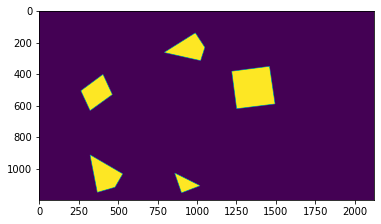

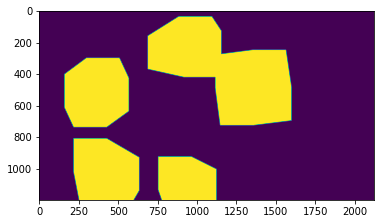

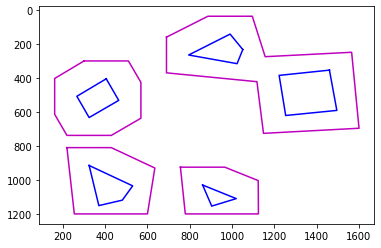

In [39]:
frame = cv2.imread("../vision/images/colors.png")

# Dilate obstacles and print them
scaled_contours, original_contours, ret = detect_obstacles(frame)

plt.figure()
plt.gca().invert_yaxis()
printGlobalNavigation(original_contours, scaled_contours)

ICI MONTRER L'AUTRE METHODE

#### Visibility graph computation

